In [ ]:
!nvidia-smi

Thu Aug 29 13:59:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-08-29 13:59:34--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2024-08-29 13:59:35--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc017974c1e11b0c9fe3510f1c1b.dl.dropboxusercontent.com/cd/0/inline/CZn7S49_oicerXAtGdkKztdTkzG_c4WYFa7xJufyK3OjD2CEbOtk4aGmu86pL42Lis-k27DTIlpjOeWev9eQtlHIiTasxtZN7GyNLSeZeFTDB_wuReaxl_ytJamOSHLCgKe3VinsQ5geCciOOlXm8HzU/file# [following]
--2024-08-29 13:59:35--  https://uc017974c1e11b0c9fe3510f1c1b.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path =Path("/content/test")

In [ ]:
# Getting Image paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/fear/Training_17997300.jpg',
 '/content/train/fear/Training_47762116.jpg',
 '/content/train/fear/Training_11771361.jpg',
 '/content/train/fear/Training_93925872.jpg',
 '/content/train/fear/Training_38188558.jpg',
 '/content/train/fear/Training_68008375.jpg',
 '/content/train/fear/Training_84941007.jpg',
 '/content/train/fear/Training_82449946.jpg',
 '/content/train/fear/Training_41083563.jpg',
 '/content/train/fear/Training_71463288.jpg']

In [ ]:
# Getting their respective labels

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
# Compute class weights

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7879694250581588, 1: 16.253776435045317, 2: 1.7382875605815833, 3: 1.0, 4: 1.464742717124966, 5: 1.475185083630381, 6: 2.2454090150250416}


In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.72 s, sys: 57.3 ms, total: 1.78 s
Wall time: 2.72 s
(32, 96, 96, 3)
(32, 7)


surprise


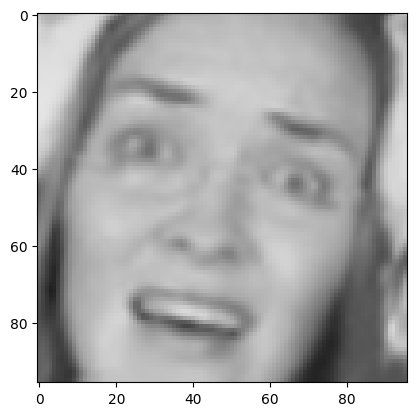

In [ ]:
# Viewing a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 33.2 ms
(32, 96, 96, 3)
(32, 7)


happy


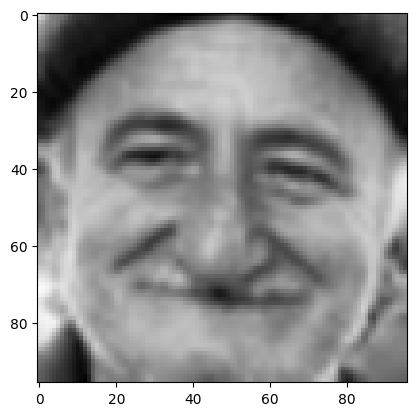

In [ ]:
# Viewing sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)
input_layer = tf.keras.layers.Input(shape=(96, 96, 3))
model = tf.keras.Sequential([
    input_layer,
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 176s 102ms/step - accuracy: 0.3220 - loss: 3.1279 - precision: 0.5493 - recall: 0.1107 - val_accuracy: 0.4428 - val_loss: 1.4447 - val_precision: 0.6318 - val_recall: 0.2568
Epoch 2/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 127s 97ms/step - accuracy: 0.4798 - loss: 2.4763 - precision: 0.6815 - recall: 0.2637 - val_accuracy: 0.5393 - val_loss: 1.2715 - val_precision: 0.6834 - val_recall: 0.3851
Epoch 3/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.5094 - loss: 2.2892 - precision: 0.6794 - recall: 0.3035 - val_accuracy: 0.5672 - val_loss: 1.1497 - val_precision: 0.7336 - val_recall: 0.3924
Epoch 4/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.5481 - loss: 2.0984 - precision: 0.7185 - recall: 0.3615 - val_accuracy: 0.5690 - val_loss: 1.1290 - val_precision: 0.7046 - val_recall: 0.4292
Epoch 5/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.5476 - loss: 2.0955 - precision: 0.7025 - recall: 0.3593 - val_accuracy: 0.5634 -

In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7949824 (30.33 MB)
Trainable params: 181

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6221 - loss: 1.6979 - precision: 0.7476 - recall: 0.4729
Epoch 1: val_loss improved from inf to 1.04746, saving model to best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 60s 89ms/step - accuracy: 0.6221 - loss: 1.6979 - precision: 0.7476 - recall: 0.4729 - val_accuracy: 0.6122 - val_loss: 1.0475 - val_precision: 0.7138 - val_recall: 0.4983
Epoch 2/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6416 - loss: 1.6085 - precision: 0.7536 - recall: 0.5056
Epoch 2: val_loss improved from 1.04746 to 1.02988, saving model to best_weights.weights.h5
672/672 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.6416 - loss: 1.6085 - precision: 0.7536 - recall: 0.5056 - val_accuracy: 0.6236 - val_loss: 1.0299 - val_precision: 0.7082 - val_recall: 0.5362
Epoch 3/8
672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6251 - loss: 1.6293 - precision: 0.7427 - recall: 0.5015
Epoch 3: val_loss did not improve from 1.02988
67

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model.build((None, 96, 96, 3))

model.load_weights("best_weights.weights.h5")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 608 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


fear


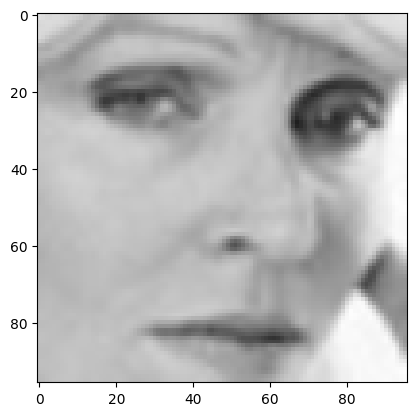

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.1604 - loss: 2.3719 - precision: 0.1818 - recall: 0.0715
 Testing Acc :  0.21565896272659302
 Testing Precision  0.22953113913536072
 Testing Recall  0.09139035642147064


In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")

In [ ]:
# Now using opencv2 for real time application

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

import dlib
import pickle

In [ ]:
def get_model():
    backbone = tf.keras.applications.EfficientNetB2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights=None
    )
    model = tf.keras.Sequential([
        backbone,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    return model

In [ ]:
model = get_model()
model.build(input_shape=(None, 96, 96, 3))
model.load_weights("best_weights.weights.h5") # Load the saved weights

In [ ]:
# Load LabelEncoder
def load_object(name):
    pickle_obj = open(f"{name}.pck","rb")
    obj = pickle.load(pickle_obj)
    return obj

Le = load_object("LabelEncoder")

In [ ]:
def ProcessImage(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    image = tf.expand_dims(image , 0)
    return image

def RealtimePrediction(image , model, encoder_):
    prediction = model.predict(image)
    prediction = np.argmax(prediction , axis = 1)
    return encoder_.inverse_transform(prediction)[0]

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

In [ ]:
VideoCapture = cv2.VideoCapture(0)

detector = dlib.get_frontal_face_detector()

while True :

    ret , frame = VideoCapture.read()

    if not ret :
        break

    gray = cv2.cvtColor( frame , cv2.COLOR_BGR2GRAY)

    rects = detector(gray , 0)

    if len(rects) >= 1 :
        for rect in rects :
            (x , y , w , h) = rect_to_bb(rect)
            img = gray[y-10 : y+h+10 , x-10 : x+w+10]

            if img.shape[0] == 0 or img.shape[1] == 0 :
                cv2.imshow("Frame", frame)

            else :
                img = cv2.cvtColor(img , cv2.COLOR_GRAY2RGB)
                img = ProcessImage(img)
                out = RealtimePrediction(img , model , Le)
                cv2.rectangle(frame, (x, y), (x+w, y+h),(0, 255, 0), 2)
                z = y - 15 if y - 15 > 15 else y + 15
                cv2.putText(frame, str(out), (x, z), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 255, 0), 2)

        cv2.imshow("Frame", frame)

    else :
        cv2.imshow("Frame", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

VideoCapture.release()
cv2.destroyAllWindows()